This notebook is the exploration of implementing simulations of mixing ONT/Illumina data to see how clustering looks. https://github.com/mbhall88/head_to_head_pipeline/issues/70#issuecomment-802649443 is the basis I am working off.


Suppose we define a ratio r which ranges from 0.1 to 0.9 (say). This is going to be the proportion of genomes which are nanopore. Suppose for the moment that we fix the bcftools threshold== compass distance.
Now suppose we follow the following

```
n=0
do {
for each sample, assign it randomly to nanopore with probability r (else illumina)
Calculate ACR5, ACP5 and add to an array
} while n<1000

```

So you basically do 1000 simulations, of which samples you picked to be nanopore and illumina, but always with r% being nanopore. Then look at a violin plot of how ACR5, ACP5 look.

Right, having done this, you can see how this varies with r.

In [1]:
import numpy as np
import pandas as pd
from itertools import chain, combinations, product
import networkx as nx
from typing import Tuple, Set
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("ggplot")
seed = 88  # set to None for no seeding
rng = np.random.default_rng(seed=seed)
PAIR_IDX = ("sample1", "sample2")
DELIM = ","

In [2]:
def tversky_index(
    A: Set[str], B: Set[str], alpha: float = 1.0, beta: float = 1.0
) -> float:
    """If we set alpha and beta to 1 then we get the Jaccard Index.
    If we set alpha to 1 and beta to 0 we get something like recall.
    If we set alpha to 0 and beta to 1 we get something like precision.
    """
    size_of_intersection = len(A & B)
    A_weight = alpha * len(A - B)
    B_weight = beta * len(B - A)
    denominator = size_of_intersection + A_weight + B_weight

    try:
        return round(size_of_intersection / denominator, 4)
    except ZeroDivisionError:
        return 0


def set_precision(A: Set[str], B: Set[str]) -> float:
    return tversky_index(A, B, alpha=0, beta=1)


def set_recall(A: Set[str], B: Set[str]) -> float:
    return tversky_index(A, B, alpha=1, beta=0)

def excess_clustering_rate(A: Set[str], B: Set[str]) -> float:
    """What percentage of true singletons are clustered.
    What percentage of A is not in B
    """
    return len(A - B) / len(A)

In [3]:
def dist_matrix_to_graph(mx: pd.Series, threshold: int) -> nx.Graph:
    edges = [(s1, s2, dist) for (s1, s2), dist in mx.iteritems() if dist <= threshold]
    graph = nx.Graph()
    graph.add_weighted_edges_from(edges)
    return graph

def truth_graph(mx: pd.Series, threshold: int) -> nx.Graph:
    names = np.unique(np.array(list(chain.from_iterable(mx.index))))
    mx = mx[combinations(names, 2)]
    return dist_matrix_to_graph(mx, threshold)

In [4]:
def load_matrix(fpath: str, delim: str = DELIM, name: str = "") -> pd.DataFrame:
    matrix = []
    with open(fpath) as instream:
        header = next(instream).rstrip()
        names = np.array(header.split(delim)[1:])
        idx = np.argsort(names)
        sorted_names = names[idx]
        for row in map(str.rstrip, instream):
            # sort row according to the name sorting
            sorted_row = np.array(row.split(delim)[1:], dtype=int)[idx]
            matrix.append(sorted_row)

    m = np.array(matrix)[idx]

    df = pd.DataFrame(m, columns=sorted_names, index=sorted_names)
    df = df.stack().rename(name).astype(int)
    df = df.rename_axis(PAIR_IDX)
    # remove the diagonal of the matrix
#     ix = [x != y for (x, y) in df.index]
#     df = df[ix]
    return df

In [5]:
def connected_components(G: nx.Graph, node: str) -> Set[str]:
    if node not in G:
        return set()
    return nx.node_connected_component(G, node)


def clustered_together(u: str, v: str, G: nx.Graph) -> bool:
    ucc = connected_components(G, u)
    if not ucc:
        return False

    vcc = connected_components(G, v)
    if not vcc:
        return False

    return ucc == vcc

In [6]:
def split(arr: np.ndarray, perc: float) -> Tuple[np.ndarray, np.ndarray]:
    split_idx = int(len(arr) * perc)
    return arr[:split_idx], arr[split_idx:]

def random_split(arr: np.ndarray, perc: float) -> Tuple[np.ndarray, np.ndarray]:
    return split(rng.permuted(arr), perc)

In [7]:
def evaluate_clustering(G_true: nx.Graph, G_test: nx.Graph) -> Tuple[float, float]:
    """Returns the ACP, ACR, and cluster size ratio for the clustering"""
    true_clusters =  [c for c in nx.connected_components(G_true)]
    acp_vals = []
    acr_vals = []
    for cluster in true_clusters:
        for node in cluster:
            test_cluster = connected_components(G_test, node)
            acr_vals.append(set_recall(cluster, test_cluster))
            acp_vals.append(set_precision(cluster, test_cluster))
            
    cluster_size_ratio = nx.number_connected_components(G_true) / nx.number_connected_components(G_test)
    return np.mean(acp_vals), np.mean(acr_vals), cluster_size_ratio

In [8]:
illumina_df = load_matrix("compass.matrix.csv", name="illumina")
ont_df = load_matrix("bcftools.matrix.csv", name="ont")
mixed_df = load_matrix("mixed.matrix.csv", name="mixed")
samples = np.unique(np.array(list(chain.from_iterable(illumina_df.index))))

In [9]:
xs = []
s = "R27937"
for (s1, s2), d in mixed_df.iteritems():
    if s == s1:
         xs.append((d, s2))
    elif s == s2:
        xs.append((d, s1))
sorted(xs)

[(0, 'R27937'),
 (2, 'R22601'),
 (3, 'R22601'),
 (4, 'R18043'),
 (5, 'R18040'),
 (5, 'R27725'),
 (6, 'R18043'),
 (7, 'R18040'),
 (8, 'R27725'),
 (9, 'R28182'),
 (9, 'R28182'),
 (11, 'R21408'),
 (12, 'R26791'),
 (13, 'R26791'),
 (20, 'R20260'),
 (22, 'R20574'),
 (28, 'R23146'),
 (29, 'R26778'),
 (31, 'R28980'),
 (32, 'R30420'),
 (33, 'R32929'),
 (49, 'R21893'),
 (59, 'R20260'),
 (59, 'R20574'),
 (60, 'R21408'),
 (71, 'R23146'),
 (71, 'R28980'),
 (72, 'R30420'),
 (73, 'R32929'),
 (74, 'R26778'),
 (87, 'R21893'),
 (381, 'R24100'),
 (392, 'mada_1-11'),
 (457, 'mada_131'),
 (464, 'mada_1-11'),
 (470, 'R25048'),
 (484, 'mada_1-6'),
 (486, '18_0622465'),
 (491, 'R30215'),
 (495, 'mada_2-42'),
 (497, 'R25048'),
 (505, 'mada_142'),
 (509, 'R37765'),
 (510, 'R27657'),
 (516, 'mada_125'),
 (520, 'R29816'),
 (522, '18_0621851'),
 (522, 'R29598'),
 (523, 'mada_1-28'),
 (524, 'R36431'),
 (525, 'R31095'),
 (527, 'R28581'),
 (528, 'mada_1-8'),
 (529, 'mada_115'),
 (530, 'R28703'),
 (534, 'R28012'),
 (

In [10]:
ratios = [0.1, 0.25, 0.5, 0.75, 0.9]
n_sims = 5
T = {
    0: {
        "ont": 0,
        "mixed": 0,
    },
    2: {
        "ont": 2,
        "mixed": 2
    },
    5: {
        "ont": 5,
        "mixed": 5
    },
    12: {
        "ont": 11,
        "mixed": 12
    }
}

In [11]:
def run_simulation(samples, ratio, threshold, G_true, N):
    eval_vals = []
    for _ in range(N):
        ont, ill = random_split(samples, ratio)
        assert not set(ill) & set(ont)
        edges = [(s1, s2, dist) for (s1, s2), dist in illumina_df[combinations(ill, 2)].iteritems() if dist <= threshold]
        t = T[threshold]["ont"]
        edges.extend([(s1, s2, dist) for (s1, s2), dist in ont_df[combinations(ont, 2)].iteritems() if dist <= t])
        t = T[threshold]["mixed"]
        edges.extend([(s1, s2, dist) for (s1, s2), dist in mixed_df[product(ill, ont)].iteritems() if dist <= t])
        G_test = nx.Graph()
        G_test.add_weighted_edges_from(edges)
        true_singletons = set(samples) - set(G_true.nodes)
        test_singletons = set(samples) - set(G_test.nodes)
        xcr = excess_clustering_rate(true_singletons, test_singletons)
        acp, acr, cnr = evaluate_clustering(G_true, G_test)
        eval_vals.append((acp, acr, 1-xcr))
    df = pd.DataFrame(zip(*eval_vals)).T.rename(columns={0:"ACP", 1:"ACR", 2: "1-XCR"}).melt(var_name="metric")
    df["ratio"] = ratio
    return df

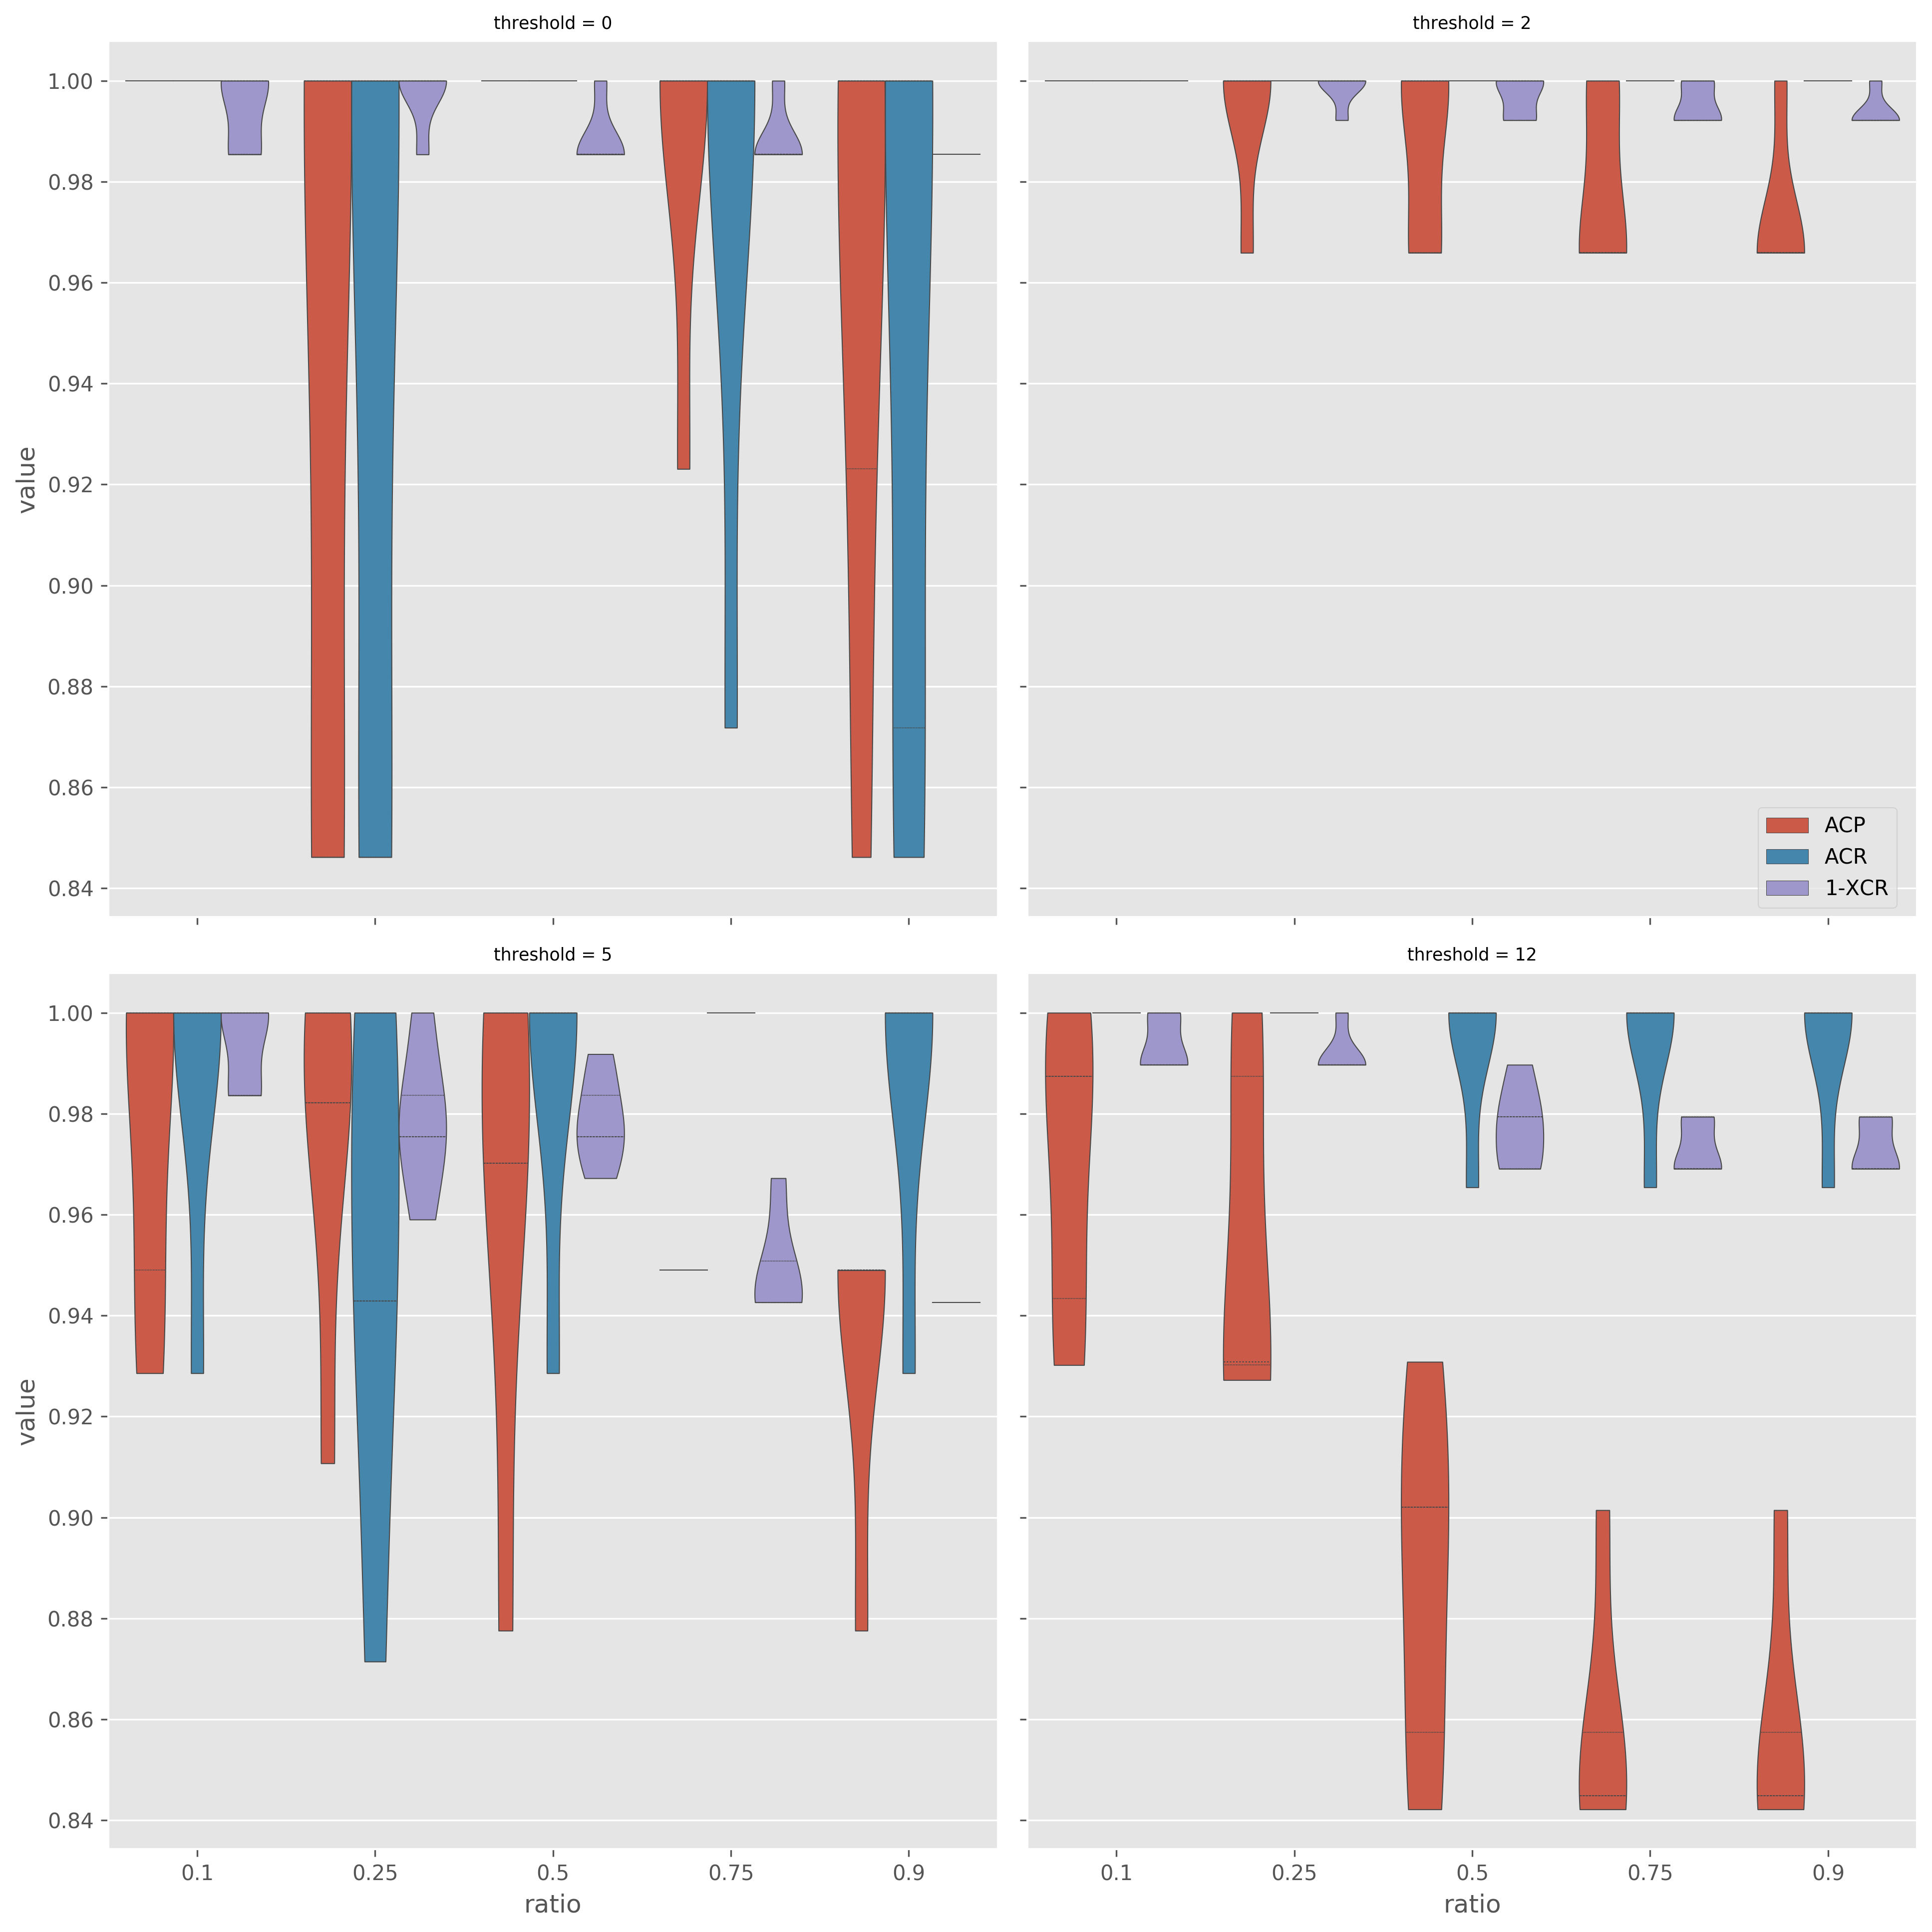

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(13, 13), dpi=300, sharex=True, sharey=True, squeeze=True)
kwargs = dict(
    x="ratio",
    y="value",
    hue="metric",
    split=False,
    scale="width",
    inner="quartile",
    cut=0,
    linewidth=0.5,
)
dfs = []
for ax, t in zip(axes.flatten(), T):
    frames = []
    G = truth_graph(illumina_df, t)
    for ratio in ratios:
        frame = run_simulation(samples, ratio, t, G, n_sims)
        frame["threshold"] = t
        frames.append(frame)
    data = pd.concat(frames)
    dfs.append(data)
    ax = sns.violinplot(data=data, ax=ax, **kwargs)
    ax.set_title(f"threshold = {t}", fontdict={'fontsize': "small"})

    ax.label_outer()
    ax.get_legend().remove()
    
# fig.subplots_adjust(wspace=0.025, hspace=0.05)
fig.tight_layout()

handles, labels = axes.flatten()[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.91, 0.53))

In [13]:
df = pd.concat(dfs)

In [14]:
grp = df.groupby(["ratio", "threshold", "metric"])

In [15]:
summary = grp.describe()

In [16]:
summary

value                                              \
                       count      mean           std       min       25%   
ratio threshold metric                                                     
0.10  0         1-XCR    5.0  0.994161  7.995950e-03  0.985401  0.985401   
                ACP      5.0  1.000000  0.000000e+00  1.000000  1.000000   
                ACR      5.0  1.000000  0.000000e+00  1.000000  1.000000   
      2         1-XCR    5.0  1.000000  0.000000e+00  1.000000  1.000000   
                ACP      5.0  1.000000  0.000000e+00  1.000000  1.000000   
                ACR      5.0  1.000000  0.000000e+00  1.000000  1.000000   
      5         1-XCR    5.0  0.993443  8.979058e-03  0.983607  0.983607   
                ACP      5.0  0.975511  3.430101e-02  0.928571  0.948982   
                ACR      5.0  0.985714  3.194383e-02  0.928571  1.000000   
      12        1-XCR    5.0  0.993814  5.646624e-03  0.989691  0.989691   
                ACP      5.0  0.969686  3.081926e-02  0.930189  0.943396   
                ACR      5.0  1.000000  0.000000e+00  1.000000  1.000000   
0.25  0         1-XCR    5.0  0.997080  6.528666e-03  0.985401  1.000000   
                ACP      5.0  0.938462  8.426501e-02  0.846154  0.846154   
                ACR      5.0  0.938462  8.426501e-02  0.846154  0.846154   
      2         1-XCR    5.0  0.998437  3.493856e-03  0.992188  1.000000   
                ACP      5.0  0.993182  1.524592e-02  0.965909  1.000000   
                ACR      5.0  1.000000  0.000000e+00  1.000000  1.000000   
      5         1-XCR    5.0  0.978689  1.489008e-02  0.959016  0.975410   
                ACP      5.0  0.975000  3.702936e-02  0.910714  0.982143   
                ACR      5.0  0.951429  5.306907e-02  0.871429  0.942857   
      12        1-XCR    5.0  0.991753  4.610449e-03  0.989691  0.989691   
                ACP      5.0  0.955130  3.552557e-02  0.927219  0.930189   
                ACR      5.0  1.000000  0.000000e+00  1.000000  1.000000   
0.50  0         1-XCR    5.0  0.988321  6.528666e-03  0.985401  0.985401   
                ACP      5.0  1.000000  0.000000e+00  1.000000  1.000000   
                ACR      5.0  1.000000  0.000000e+00  1.000000  1.000000   
      2         1-XCR    5.0  0.996875  4.279082e-03  0.992188  0.992188   
                ACP      5.0  0.986364  1.867236e-02  0.965909  0.965909   
                ACR      5.0  1.000000  0.000000e+00  1.000000  1.000000   
      5         1-XCR    5.0  0.978689  9.345700e-03  0.967213  0.975410   
                ACP      5.0  0.963604  5.035345e-02  0.877554  0.970232   
                ACR      5.0  0.985714  3.194383e-02  0.928571  1.000000   
      12        1-XCR    5.0  0.977320  8.625361e-03  0.969072  0.969072   
                ACP      5.0  0.886899  3.627005e-02  0.842140  0.857408   
                ACR      5.0  0.993081  1.547106e-02  0.965406  1.000000   
0.75  0         1-XCR    5.0  0.988321  6.528666e-03  0.985401  0.985401   
                ACP      5.0  0.984615  3.440105e-02  0.923077  1.000000   
                ACR      5.0  0.974360  5.733278e-02  0.871800  1.000000   
      2         1-XCR    5.0  0.995313  4.279082e-03  0.992188  0.992188   
                ACP      5.0  0.979545  1.867236e-02  0.965909  0.965909   
                ACR      5.0  1.000000  0.000000e+00  1.000000  1.000000   
      5         1-XCR    5.0  0.949180  1.068722e-02  0.942623  0.942623   
                ACP      5.0  0.948982  1.241267e-16  0.948982  0.948982   
                ACR      5.0  1.000000  0.000000e+00  1.000000  1.000000   
      12        1-XCR    5.0  0.973196  5.646624e-03  0.969072  0.969072   
                ACP      5.0  0.858128  2.492598e-02  0.842140  0.844830   
                ACR      5.0  0.993081  1.547106e-02  0.965406  1.000000   
0.90  0         1-XCR    5.0  0.985401  0.000000e+00  0.985401  0.985401   
                ACP      5.0  0.953846  6.880209e-02  0.846154  0.92307

In [17]:
with open("test.json", "w") as fout:
#     fout.write(summary.to_html())
    summary.to_json(fout)

In [18]:
type(illumina_df)

pandas.core.series.Series

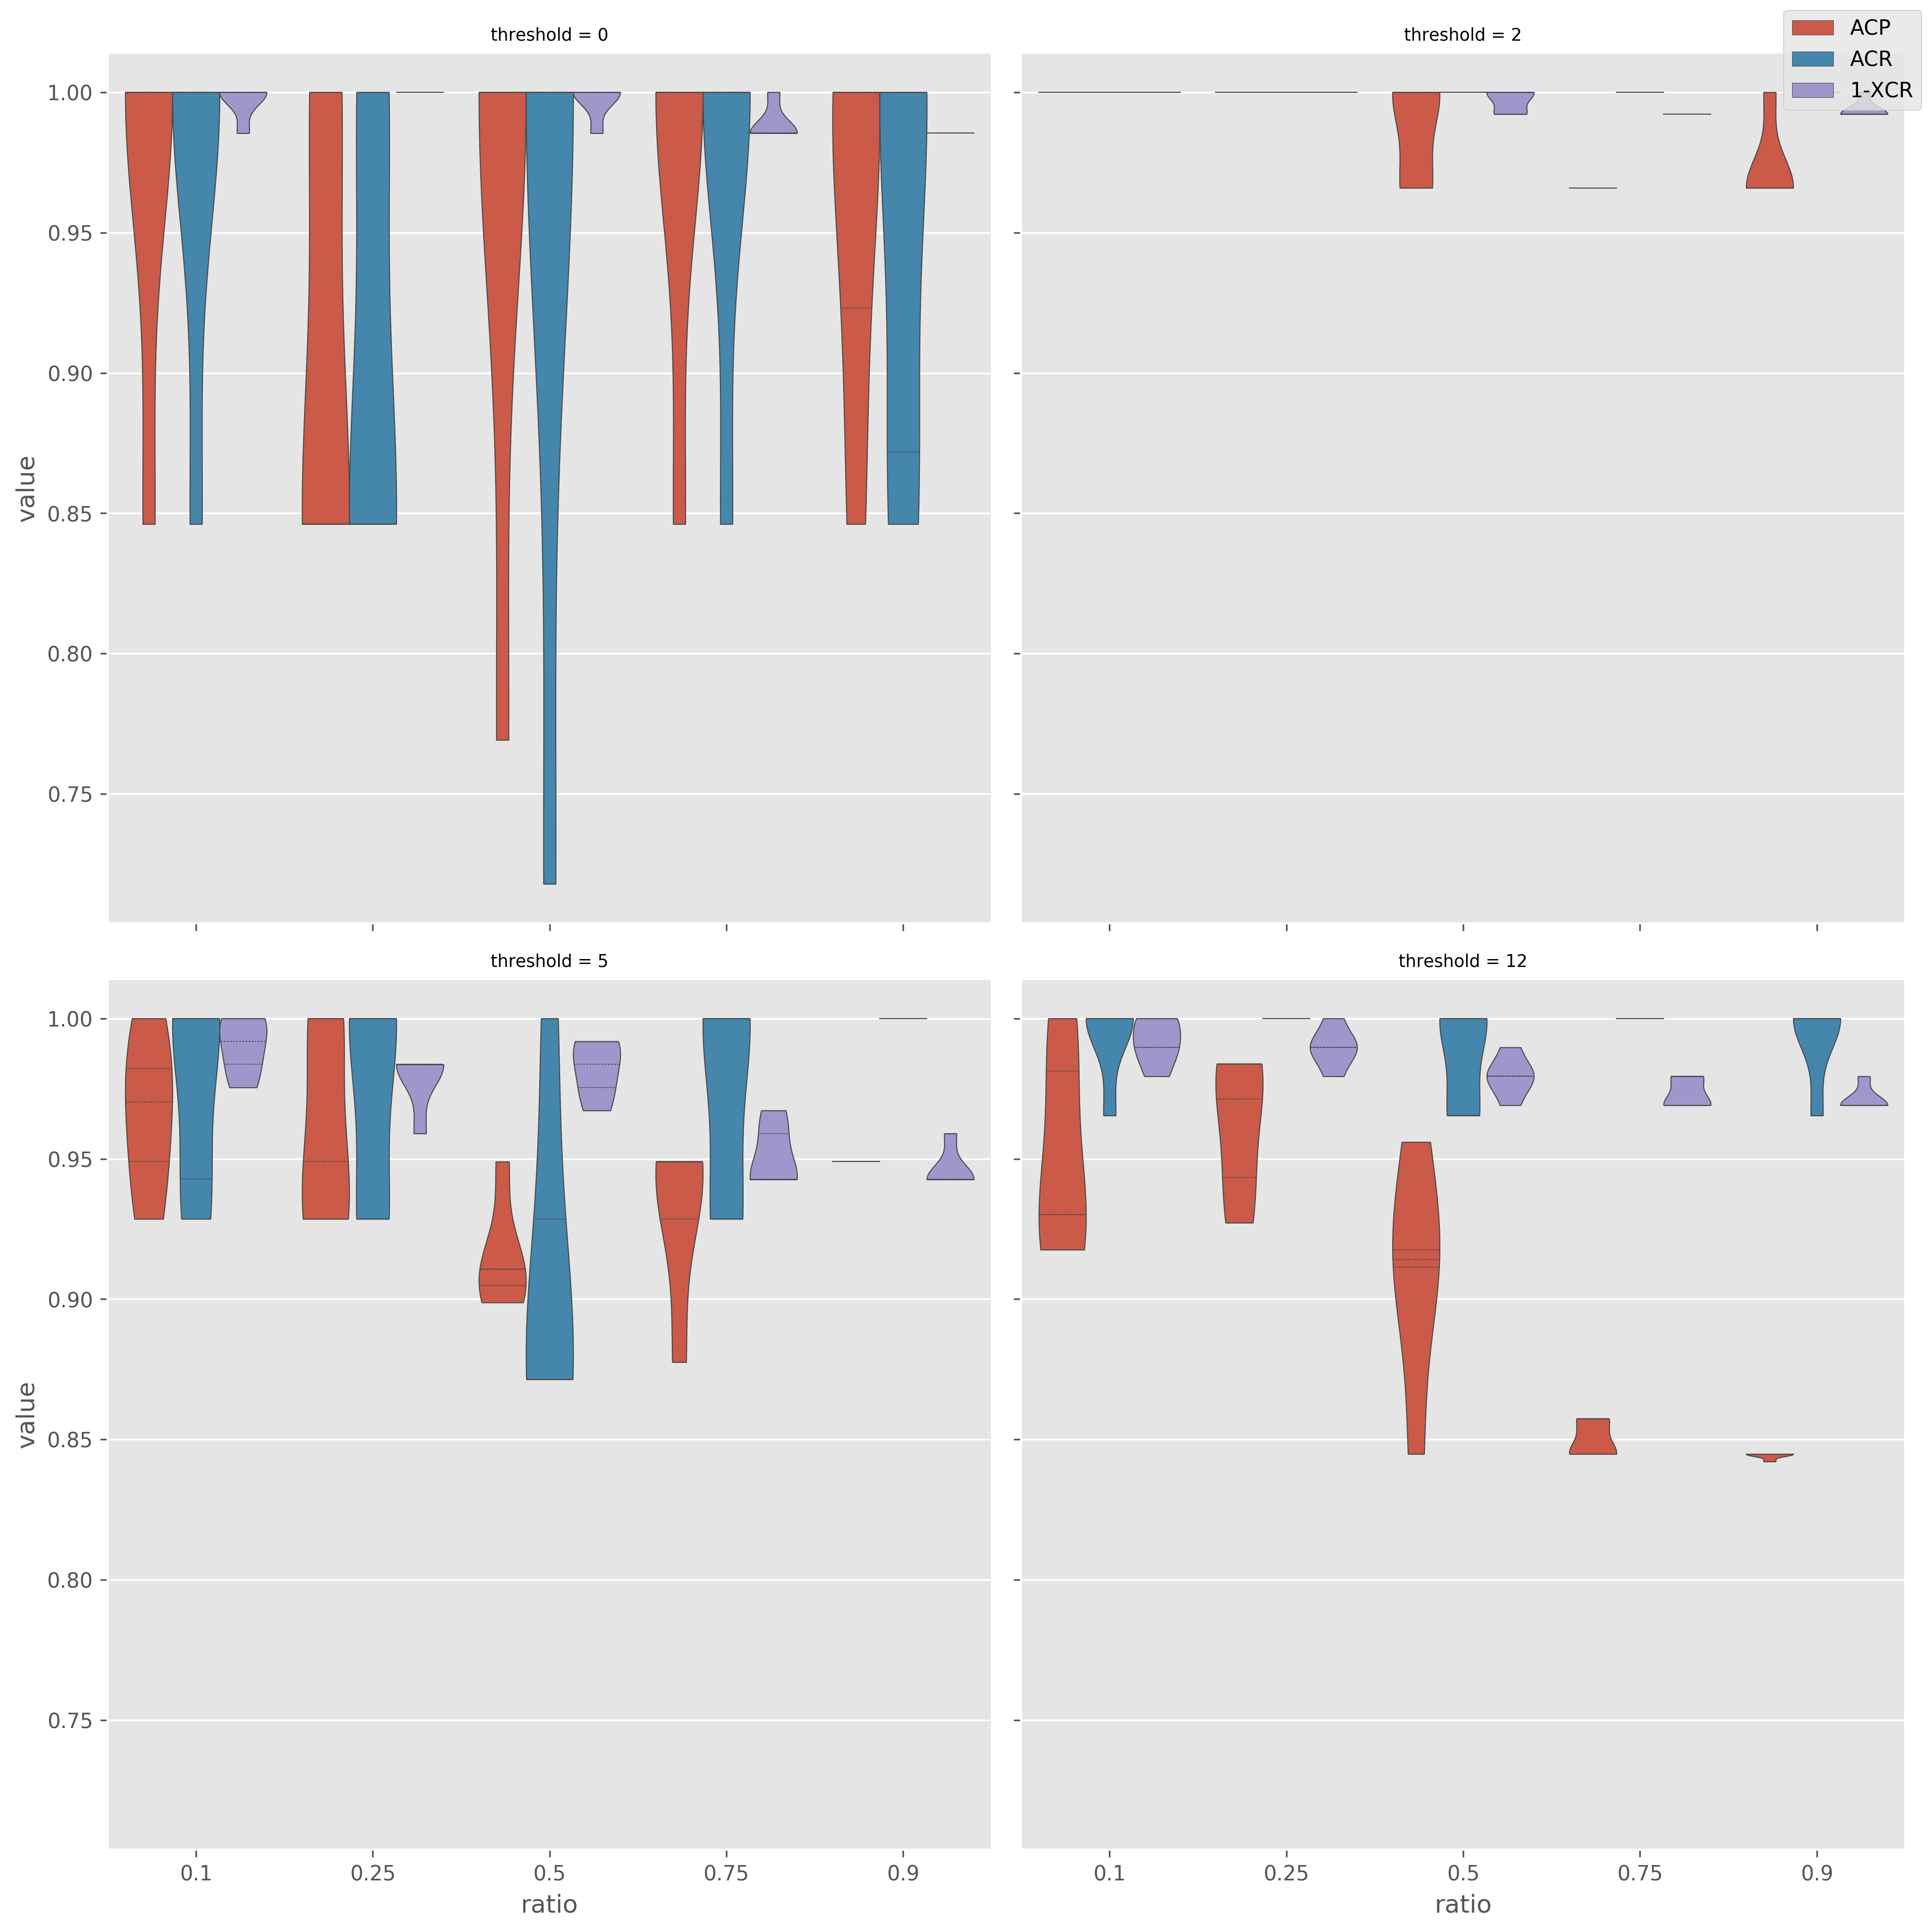

In [19]:
# version without CNR
fig, axes = plt.subplots(2, 2, figsize=(13, 13), dpi=300, sharex=True, sharey=True, squeeze=True)
kwargs = dict(
    x="ratio",
    y="value",
    hue="metric",
    split=False,
    scale="width",
    inner="quartile",
    cut=0,
    linewidth=0.5,
)
dfs = []
for ax, t in zip(axes.flatten(), T):
    frames = []
    G = truth_graph(illumina_df, t)
    for ratio in ratios:
        frame = run_simulation(samples, ratio, t, G, n_sims)
        frame["threshold"] = t
        frames.append(frame)
    data = pd.concat(frames).query("metric != 'CNR'")
    dfs.append(data)
    ax = sns.violinplot(data=data, ax=ax, **kwargs)
    ax.set_title(f"threshold = {t}", fontdict={'fontsize': "small"})

    ax.label_outer()
    ax.get_legend().remove()
    
# fig.subplots_adjust(wspace=0.025, hspace=0.05)
fig.tight_layout()

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels)

In [20]:
table = pd.read_html("mixed_simulations.summary.html")[0]

In [21]:
table.columns = ["ratio", "threshold", "metric", "count", "mean", "std", "min", "25%", "50%", "75%", "max"]

In [22]:
table

,ratio,threshold,metric,count,mean,std,min,25%,50%,75%,max
0,0.01,0,1-XCR,1000.0,0.000073,0.001030,0.000000,0.000000,0.000000,0.000000,0.014599
1,0.01,0,SACP,1000.0,0.997692,0.016703,0.846154,1.000000,1.000000,1.000000,1.000000
2,0.01,0,SACR,1000.0,0.997077,0.020052,0.846154,1.000000,1.000000,1.000000,1.000000
3,0.01,2,1-XCR,1000.0,0.000031,0.000493,0.000000,0.000000,0.000000,0.000000,0.007812
4,0.01,2,SACP,1000.0,0.999864,0.002153,0.965909,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
79,0.90,5,SACP,1000.0,0.944180,0.023168,0.877554,0.948982,0.948982,0.948982,1.000000
80,0.90,5,SACR,1000.0,0.992057,0.022303,0.928571,1.000000,1.000000,1.000000,1.000000
81,0.90,12,1-XCR,1000.0,0.028701,0.004512,0.010309,0.030928,0.030928,0.030928,0.030928
82,0.90,12,SACP,1000.0,0.855417,0.022494,0.842140,0.844830,0.844830,0.857408,0.971245


In [23]:
table.query("metric == '1-XCR' and threshold==5")

,ratio,threshold,metric,count,mean,std,min,25%,50%,75%,max
6,0.01,5,1-XCR,1000.0,0.000385,0.002388,0.000000,0.000000,0.000000,0.000000,0.016393
18,0.05,5,1-XCR,1000.0,0.002697,0.006042,0.000000,0.000000,0.000000,0.000000,0.032787
30,0.10,5,1-XCR,1000.0,0.005820,0.008756,0.000000,0.000000,0.000000,0.016393,0.040984
42,0.25,5,1-XCR,1000.0,0.014615,0.012646,0.000000,0.000000,0.016393,0.024590,0.057377
54,0.50,5,1-XCR,1000.0,0.028566,0.015460,0.000000,0.016393,0.032787,0.040984,0.057377
66,0.75,5,1-XCR,1000.0,0.042090,0.013715,0.000000,0.032787,0.040984,0.057377,0.057377
78,0.90,5,1-XCR,1000.0,0.051615,0.009346,0.016393,0.049180,0.057377,0.057377,0.057377


In [24]:
xs = [d for (s1, s2), d in mixed_df.iteritems() if s1==s2]

In [25]:
xs = np.array(xs)

In [26]:
l = len(xs)
for d in range(1, 10):
    n = sum(xs<d)
    print(f"{n/l:.1%} ({n}/{l}) less than {d}")

64.0% (96/150) less than 1
84.0% (126/150) less than 2
92.7% (139/150) less than 3
96.0% (144/150) less than 4
97.3% (146/150) less than 5
98.0% (147/150) less than 6
98.0% (147/150) less than 7
98.7% (148/150) less than 8
99.3% (149/150) less than 9


In [27]:
np.linspace(0.1, 1, 10)

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [30]:
pd.Series(xs).describe()

count    150.000000
mean       1.013333
std        4.451056
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       53.000000
dtype: float64

In [32]:
sorted(xs, reverse=True)


[53,
 8,
 7,
 5,
 4,
 4,
 3,
 3,
 3,
 3,
 3,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]